In [32]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fn 1: Root Mean Squared Percentage Error Function

According to Kaggle, submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as such:

$$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\frac{y_i - \hat{y}_i}{y_i}\right)^{2}}$$

The code below is a function that calculates the RMSPE.

In [33]:
# Function that calculates and returns the RMSPE
def rmspe(y_test, y_pred):
    
    y_test=np.array(y_test)
    y_pred=np.array(y_pred)

    ytest_ypred = pd.DataFrame(y_test, y_pred).reset_index()
    ytest_ypred.columns = ['Predicted_Sales','Actual_Sales']

    # Removing rows that contain zero to prevent division by zero when calculating RMSPE
    ytest_ypred.drop(ytest_ypred[ytest_ypred['Actual_Sales']==0].index,axis=0, inplace=True)

    rmspe = np.sqrt(np.mean(((ytest_ypred['Actual_Sales']-ytest_ypred['Predicted_Sales']) / ytest_ypred['Actual_Sales']) ** 2))
    return rmspe

# Fn 2: Residuals Plotting Function

The code below is a function that plots the residuals against time. Residuals are defined as the difference between the actual sales values and the predicted sales values.

Residual plots are a way to visualize how the errors are distributed. Ideally, the errors should be distributed randomly with a mean of zero, and the standard deviation of the errors should not change with time.

In [34]:
# Function that plots residuals against time for train_validation dataset
def residual_plot(y_pred, train_sub_val_file_path, model_type):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    plotting_df = pd.DataFrame()
    plotting_df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    plotting_df['Predicted_Sales'] = np.array(y_pred)

    plotting_df['Residuals'] = plotting_df['Sales'] - plotting_df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = plotting_df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = plotting_df['Residuals'].std()
    
    # Plotting the residuals
    fig, ax = plt.subplots(figsize = (16,8))
    ax.scatter(plotting_df['Date'].values, plotting_df['Residuals'].values, marker='+', alpha = 0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales residuals')
    ax.set_title('Scatterplot of {} residuals against time'.format(model_type))
    
    # Plotting the mean of residuals as a horizontal line
    ax.axhline(y=residual_mean, color='black')
    ax.text('2015-06-08', residual_mean, 'mean={:.1f}'.format(residual_mean), fontsize=10, backgroundcolor='w')
    
    # Plotting the first standard deviations as horizontal lines
    ax.axhline(y=residual_mean+residual_std, color='black', linestyle = ':')
    ax.axhline(y=residual_mean-residual_std, color='black', linestyle = ':')
    ax.text('2015-08-05', residual_mean+residual_std, '+1 standard deviation', fontsize=10, backgroundcolor='w')
    ax.text('2015-08-05', residual_mean-residual_std, '-1 standard deviation', fontsize=10, backgroundcolor='w')
    
    return ax

# Fn 3: Residual mean and standard deviation function

The code below is a function that calculates and returns the mean and standard deviations of the residuals

In [35]:
def residual_mean_std(y_pred, train_sub_val_file_path):
    
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    df = pd.DataFrame()
    df[['Date','Sales']] = train_sub_validation[['Date', 'Sales']]
    df['Predicted_Sales'] = np.array(y_pred)
    df['Residuals'] = df['Sales'] - df['Predicted_Sales']
    
    # Calculating the mean
    residual_mean = df['Residuals'].mean()
    
    # Calculating the standard deviations
    residual_std = df['Residuals'].std()
    
    return(residual_mean, residual_std)

# Fn 4: Actual sales vs Predicted sales plot function

The code below is a function that plots out the time series plots of actual sales and predicted sales of selected stores in the train_validation dataset.

In [36]:
# Plotting the actual sales and predicted sales of the train_validation dataframe for selected stores
def actual_pred_sales_plot(y_pred, train_sub_val_file_path):

    # Import train_validation.csv into a dataframe
    train_sub_validation = pd.read_csv(train_sub_val_file_path, index_col = 0, dtype=types)
    train_sub_validation['Date'] = pd.to_datetime(train_sub_validation['Date'])
    
    # Incorporate y_pred into train_validation dataframe
    train_sub_validation['Predicted_Sales'] = y_pred
    
    selected_stores = [2, 7, 85, 259, 562, 1, 4, 732, 530, 512]

    for store_id in selected_stores:
        fig, ax = plt.subplots(figsize = (16,3))
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Sales'])
        ax.plot(train_sub_validation[train_sub_validation['Store']==store_id]['Date'], train_sub_validation[train_sub_validation['Store']==store_id]['Predicted_Sales'])
        ax.set_title('Plot of actual sales and predicted sales against time for Store {}'.format(store_id))
        ax.set_ylabel('Sales')
        plt.legend()
        plt.show()

    return ax

# Fn 5: Random Forest Hyperparameter Tuning Function

The code below is a function that tries out different value of n_estimators in our Random Forest model.

**n_estimators - the number of decision trees used in the Random Forest model.**

The reason for creating our own Hyperparameter tuning function instead of using Scikit-Learn's GridSearchCV function is because GridSearchCV does k-folds cross-validation on our dataset. We cannot perform this action on a time series, since this would mean we are using data in the future to validate data in the past. We are only allowed to use data in the past to validate data in the future.

In [37]:
def RF_Hyperparameter_Tuning(X_train_sub, y_train_sub, X_train_sub_validation, y_train_sub_validation):
    
    from sklearn.ensemble import RandomForestRegressor

    # Dictionary that holds the values of n_estimators we want to try out
    hyperparameter_dict={'n_estimators':[25,50,100,150,200]}

    # Dictionary that holds the values of n_estimators and the corresponding rmspe score for each n_estimator
    hyperparameter_rmspe = {'n_estimators': [],'rmspe':[]}

    i = 0

    while i < 5:
        for key, value in hyperparameter_dict.items():
            hyperparameter_rmspe[key].append(value[i])

            print('Hyperparameters used:')
            print('n_estimators: {}'.format(hyperparameter_rmspe['n_estimators'][i]),'\n')

        # Instantiate our RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=hyperparameter_rmspe['n_estimators'][i],random_state=1,n_jobs=-1,verbose=1)

        # Training our RandomForestRegressor model
        rf.fit(X_train_sub, y_train_sub)

        # Predicting the test set labels
        y_pred = rf.predict(X_train_sub_validation)

        # Calculate the RMSPE of our Random Forest
        print('The rmspe of our Random Forest model is:',rmspe(y_train_sub_validation, y_pred))

        # Demarcating the end of the printouts of one loop from the next loop
        print('\n')
        print('-'*50)

        # Append the calculated rmspe to hyperparameter_rmspe
        hyperparameter_rmspe['rmspe'].append(rmspe(y_train_sub_validation, y_pred))

        i = i+1

    # Convert hyperparameter_rmspe from dictionary to DataFrame for easy viewing
    hyperparameter_rmspe_df = pd.DataFrame.from_dict(hyperparameter_rmspe)

    return hyperparameter_rmspe_df

# Random Forest Model #4

We will be using the Random Forest algorithm to train our model.

The advantages of using the Random Forest model are:
1. Being a tree-based model, it can describe non-linear dependencies between features and the target.
2. There is less preprocessing work required to be performed on the features - no need to perform one-hot encoding, and no need to standardize the features.

The second point has the greater impact on the choice of using a tree-based model for our dataset. This is because we are predicting the sales for 1,115 stores. Performing one-hot encoding on the stores would produce well over 1,000 features, and this would make our preprocessing work more difficult and the model fitting time longer.

In Random Forest Model #4, we will use the following features to predict sales:
1. Store (the store number)
2. DayOfWeek
3. Open
4. Promo
5. Mean_Sales_DoW
6. Mean_Customer_DoW
7. SchoolHoliday
8. StateHoliday
9. Year
10. Month
11. Week
12. Mean_Sales_per_Customer
13. StoreType
14. Assortment

We will need to create features for **Mean_Sales_DoW**, **Mean_Customer_DoW**,**Year**, **Month**, **Week**, and **Mean_Sales_per_Customer**.

## 1. Feature Engineering on train_sub

In [41]:
# Import the train_sub dataset
types = {'StateHoliday': np.dtype(str)}
train_sub = pd.read_csv('train_sub_RFModel3.csv', dtype=types, parse_dates=[3]).iloc[:,1:]

# Import the store dataset
store = pd.read_csv('store.csv')

# Left join the store dataset to train_sub
train_sub1 = pd.merge(train_sub, store, how='left', on='Store')

# Encode the elements in 'StoreType' column with numbers
mapper_storetype ={'a':0,'b':1,'c':2,'d':3}
train_sub1['StoreType'] = train_sub1['StoreType'].replace(mapper_storetype)

# Encode the elements in 'Assortment' column with numbers
mapper_assortment ={'a':0,'b':1,'c':2}
train_sub1['Assortment'] = train_sub1['Assortment'].replace(mapper_assortment)

# Impute all NaN with zeros
train_sub1.fillna(0,inplace=True)

# Create a new column called 'Month_str'
mapper_month ={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
train_sub1['Month_str'] = train_sub1['Month'].replace(mapper_month)

# Create a new feature called 'IsPromo2Month'
train_sub1.loc[train_sub1['PromoInterval'] == 0, 'PromoInterval'] = ''
train_sub1['IsPromo2Month'] = 0
for interval in train_sub1['PromoInterval'].unique():
    if interval != '':
        for month in interval.split(','):
            train_sub1.loc[(train_sub1['Month_str'] == month) & (train_sub1['PromoInterval'] == interval), "IsPromo2Month"] = 1

# Choose only the features we will use for our Random Forest Model #4
RFModel4_features = ['Store','DayOfWeek','Open','Promo','SchoolHoliday','StateHoliday','Year','Month','Week',
                     'Mean_Sales_DoW','Mean_Customers_DoW','Mean_Sales_per_Customer','StoreType','Assortment',
                    'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                    'Promo2SinceWeek','Promo2SinceYear','IsPromo2Month']
train_sub_RFModel4 = train_sub1[RFModel4_features]

train_sub_RFModel4.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW,...,Mean_Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,IsPromo2Month
0,1,5,1,1,0,0,2015,6,25,4527.945736,...,8.393519,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,1,1,0,0,2015,6,25,4455.550388,...,8.339006,0,0,570.0,11.0,2007.0,1,13.0,2010.0,0
2,3,5,1,1,0,0,2015,6,25,6821.472868,...,9.114232,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,0
3,4,5,1,1,0,0,2015,6,25,8995.720930,...,7.236247,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,1,1,0,0,2015,6,25,4622.581395,...,8.546350,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0


In [8]:
# Create the target variable for train_sub
y_train_sub = train_sub['Sales'].values

## 2. Feature Engineering on train_sub_validation

In [9]:
# Import the train_sub dataset
types = {'StateHoliday': np.dtype(str)}
train_sub_validation = pd.read_csv('train_sub_validation_RFModel3.csv', dtype=types, parse_dates=[3]).iloc[:,1:]

# Import the store dataset
store = pd.read_csv('store.csv')

# Left join the store dataset to train_sub
train_sub_validation1 = pd.merge(train_sub_validation, store, how='left', on='Store')

# Encode the elements in 'StoreType' column with numbers
mapper_storetype ={'a':0,'b':1,'c':2,'d':3}
train_sub_validation1['StoreType'] = train_sub_validation1['StoreType'].replace(mapper_storetype)

# Encode the elements in 'Assortment' column with numbers
mapper_assortment ={'a':0,'b':1,'c':2}
train_sub_validation1['Assortment'] = train_sub_validation1['Assortment'].replace(mapper_assortment)

# Impute all NaN with zeros
train_sub_validation1.fillna(0,inplace=True)

# Create a new column called 'Month_str'
mapper_month ={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
train_sub_validation1['Month_str'] = train_sub_validation1['Month'].replace(mapper_month)

# Create a new feature called 'IsPromo2Month'
train_sub_validation1.loc[train_sub_validation1['PromoInterval'] == 0, 'PromoInterval'] = ''
train_sub_validation1['IsPromo2Month'] = 0
for interval in train_sub_validation1['PromoInterval'].unique():
    if interval != '':
        for month in interval.split(','):
            train_sub_validation1.loc[(train_sub_validation1['Month_str'] == month) & (train_sub_validation1['PromoInterval'] == interval), "IsPromo2Month"] = 1
            
# Choose only the features we will use for our Random Forest Model #4
train_sub_validation_RFModel4 = train_sub_validation1[RFModel4_features]

train_sub_validation_RFModel4.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW,...,Mean_Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,IsPromo2Month
0,1,5,1,1,1,0,2015,7,31,4527.945736,...,8.393519,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,1,1,1,0,2015,7,31,4455.550388,...,8.339006,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,1,1,1,0,2015,7,31,6821.472868,...,9.114232,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,1,1,1,0,2015,7,31,8995.720930,...,7.236247,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,1,1,1,0,2015,7,31,4622.581395,...,8.546350,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0


In [10]:
# Create the target variable for train_sub_validation
y_train_sub_validation = train_sub_validation['Sales'].values

## 3. Feature Engineering on test data set

In [11]:
# Import the train_sub dataset
types = {'StateHoliday': np.dtype(str)}
test = pd.read_csv('test_RFModel3.csv', dtype=types, parse_dates=[3]).iloc[:,1:]

# Import the store dataset
store = pd.read_csv('store.csv')

# Left join the store dataset to train_sub
test1 = pd.merge(test, store, how='left', on='Store')

# Encode the elements in 'StoreType' column with numbers
mapper_storetype ={'a':0,'b':1,'c':2,'d':3}
test1['StoreType'] = test1['StoreType'].replace(mapper_storetype)

# Encode the elements in 'Assortment' column with numbers
mapper_assortment ={'a':0,'b':1,'c':2}
test1['Assortment'] = test1['Assortment'].replace(mapper_assortment)

# Impute all NaN with zeros
test1.fillna(0,inplace=True)

# Create a new column called 'Month_str'
mapper_month ={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
test1['Month_str'] = test1['Month'].replace(mapper_month)

# Create a new feature called 'IsPromo2Month'
test1.loc[test1['PromoInterval'] == 0, 'PromoInterval'] = ''
test1['IsPromo2Month'] = 0
for interval in test1['PromoInterval'].unique():
    if interval != '':
        for month in interval.split(','):
            test1.loc[(test1['Month_str'] == month) & (test1['PromoInterval'] == interval), "IsPromo2Month"] = 1
            
# Choose only the features we will use for our Random Forest Model #4
test_RFModel4 = test1[RFModel4_features]

test_RFModel4.tail()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Year,Month,Week,Mean_Sales_DoW,...,Mean_Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,IsPromo2Month
41083,1111,6,1.0,0,0,0,2015,8,31,3319.335938,...,11.972019,0,0,1900.0,6.0,2014.0,1,31.0,2013.0,0
41084,1112,6,1.0,0,0,0,2015,8,31,8663.851562,...,11.315127,2,2,1880.0,4.0,2006.0,0,0.0,0.0,0
41085,1113,6,1.0,0,0,0,2015,8,31,5912.359375,...,9.313323,0,2,9260.0,0.0,0.0,0,0.0,0.0,0
41086,1114,6,1.0,0,0,0,2015,8,31,21957.921875,...,6.178138,0,2,870.0,0.0,0.0,0,0.0,0.0,0
41087,1115,6,1.0,0,1,0,2015,8,31,6759.890625,...,14.006054,3,2,5350.0,0.0,0.0,1,22.0,2012.0,0


## 4. Hyperparameter tuning of Random Forest Model #4

In [16]:
RF_Hyperparameter_Tuning(train_sub_RFModel4, y_train_sub, train_sub_validation_RFModel4, y_train_sub_validation)

Hyperparameters used:
n_estimators: 25 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished


The rmspe of our Random Forest model is: 0.13726772092651193


--------------------------------------------------
Hyperparameters used:
n_estimators: 50 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


The rmspe of our Random Forest model is: 0.1362007681880522


--------------------------------------------------
Hyperparameters used:
n_estimators: 100 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished


The rmspe of our Random Forest model is: 0.13573053452444775


--------------------------------------------------
Hyperparameters used:
n_estimators: 150 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   18.0s finished


The rmspe of our Random Forest model is: 0.1357614079272171


--------------------------------------------------
Hyperparameters used:
n_estimators: 200 



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   30.0s finished


The rmspe of our Random Forest model is: 0.135806576045534


--------------------------------------------------


,n_estimators,rmspe
0,25,0.137268
1,50,0.136201
2,100,0.135731
3,150,0.135761
4,200,0.135807


## 5. Training Random Forest Model #4

We shall use 100 trees for our training.

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate our RandomForestRegressor
rf_m4 = RandomForestRegressor(n_estimators=100,random_state=1,n_jobs=-1,verbose=1)

# Training our RandomForestRegressor model
rf_m4.fit(train_sub_RFModel4, y_train_sub)

# Predicting the test set labels
y_pred = rf_m4.predict(train_sub_validation_RFModel4)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


## 6. Scoring Random Forest Model #4 on train_sub_validation data set

In [18]:
# Calculate the RMSPE of our Random Forest
rmspe(y_train_sub_validation, y_pred)

0.13573053452444775

## 7. Plot the residuals

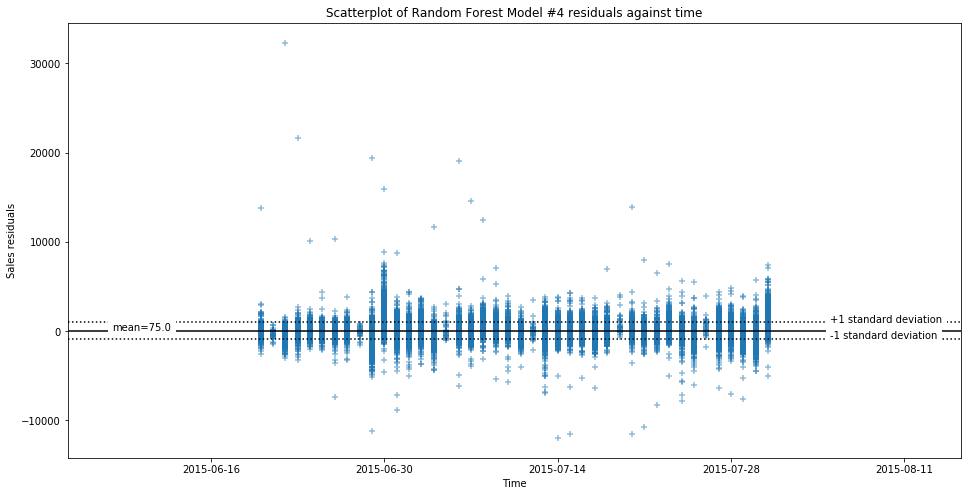

In [19]:
# Plot the residuals
residual_plot(y_pred, 'train_sub_validation.csv','Random Forest Model #4')
plt.show()

## 8. Calculate the mean and standard deviation of the residuals

In [20]:
# Mean of Random Forest model #4 residuals
print('The mean of the residuals of RF Model #4 is {:.3f}'.format(residual_mean_std(y_pred, 'train_sub_validation.csv')[0]))

# Standard deviation of Random Forest model #4 residuals
print('The standard deviation of the residuals of RF Model #4 is {:.3f}'.format(residual_mean_std(y_pred, 'train_sub_validation.csv')[1]))

The mean of the residuals of RF Model #4 is 75.047
The standard deviation of the residuals of RF Model #4 is 930.443


## 9. Plot Actual Sales and Predicted Sales against time

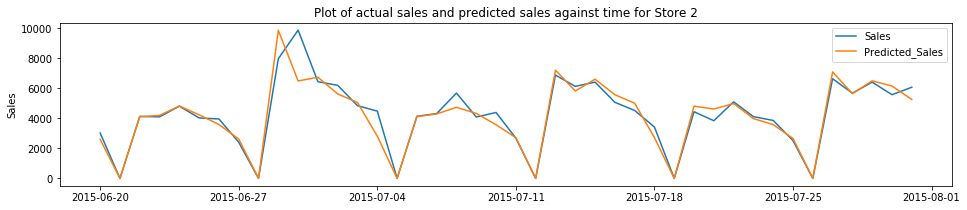

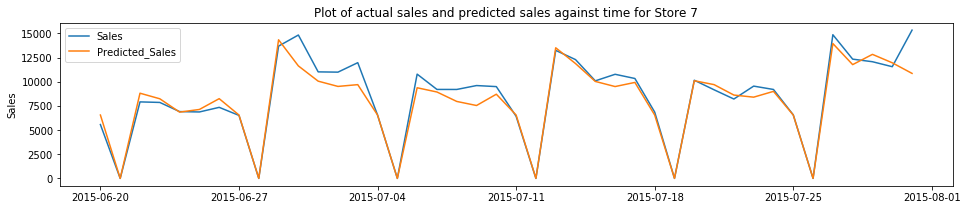

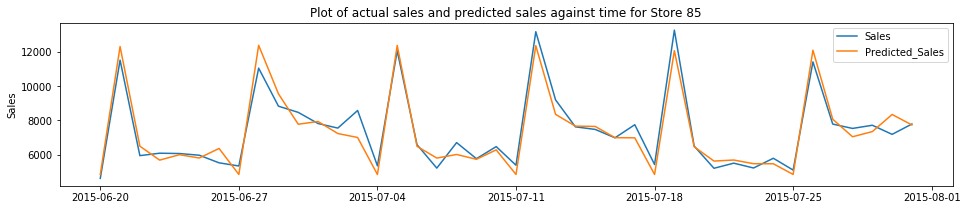

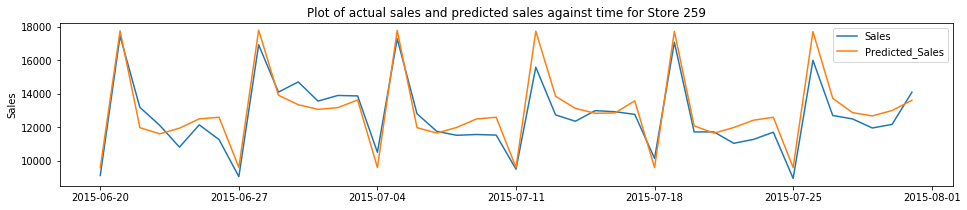

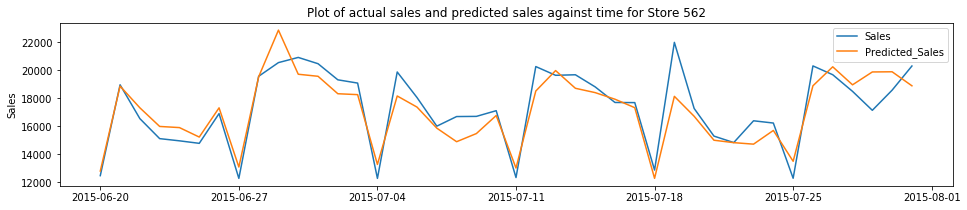

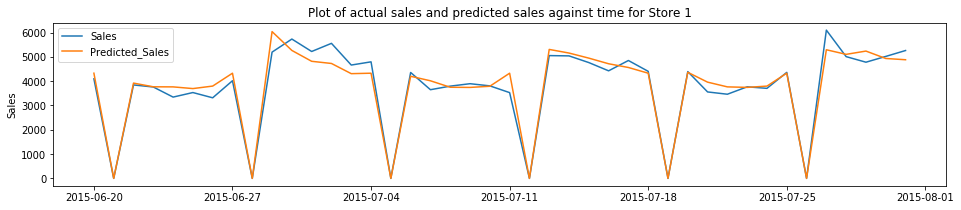

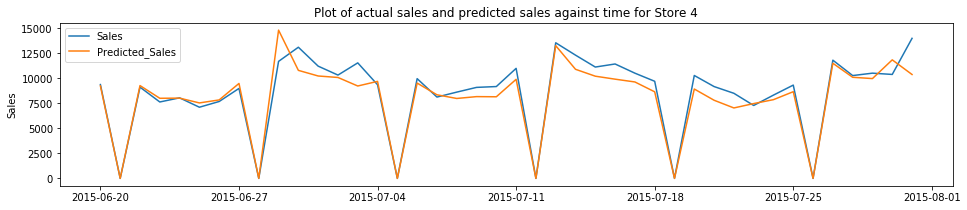

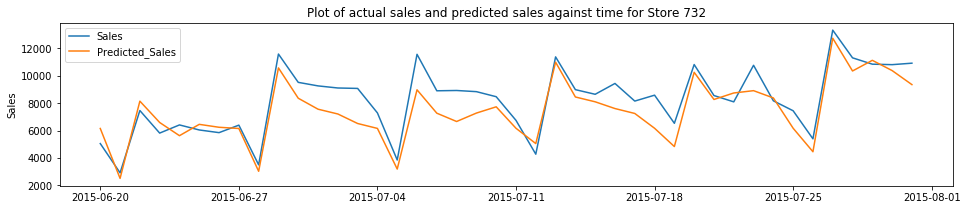

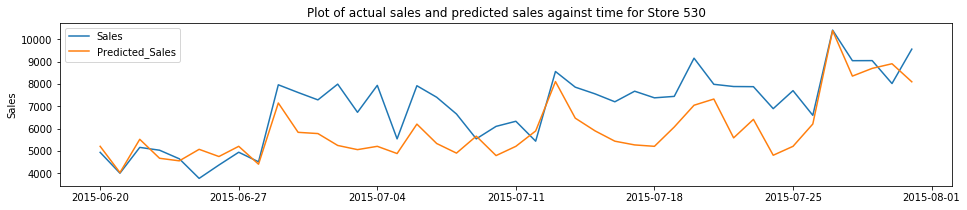

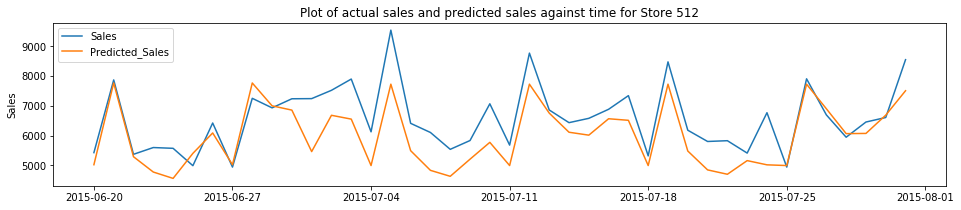

In [21]:
actual_pred_sales_plot(y_pred, 'train_sub_validation.csv')
plt.show()

## 10. Random Forest Model #4 - Feature Importances

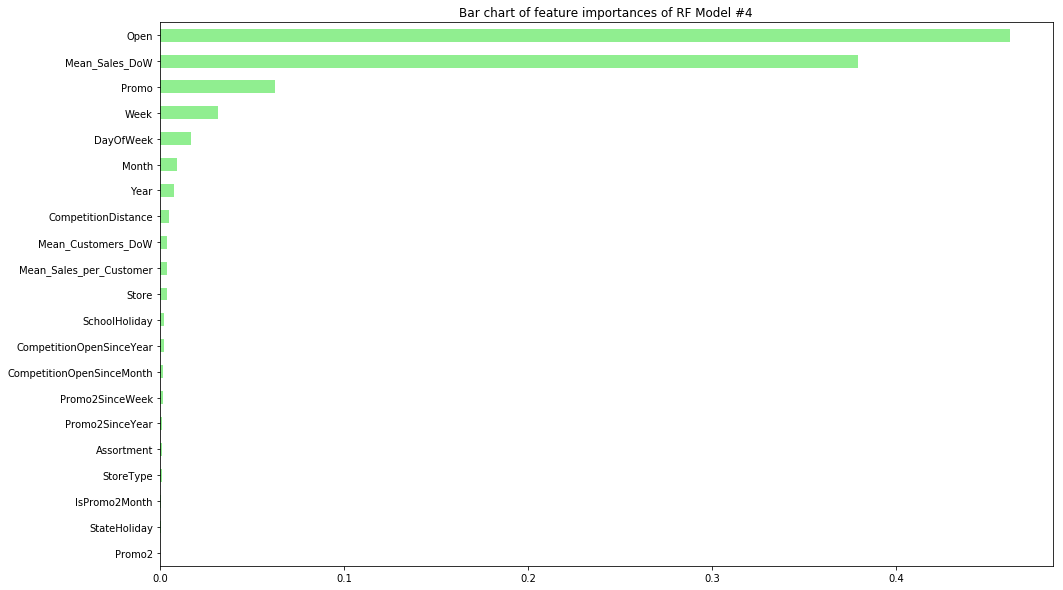

In [24]:
# Extract the feature importances
importance_rf_m4 = pd.Series(rf_m4.feature_importances_, index=train_sub_RFModel4.columns)
sorted_importance_rf_m4 = importance_rf_m4.sort_values()

# Plot the sorted importances
fig, ax = plt.subplots(figsize=(16,10))
sorted_importance_rf_m4.plot(kind='barh', color='lightgreen', ax=ax)
ax.set_title('Bar chart of feature importances of RF Model #4')
plt.show()

## 11. Evaluation of Random Forest Model #4 on test set

We will be generating sales predictions for the test set, and upload the results to Kaggle to see what score will be achieved.

In [23]:
# Generating the predictions for test set
y_pred_test = rf_m4.predict(test_RFModel4)

# Import the test dataset
types = {'StateHoliday': np.dtype(str)}
test = pd.read_csv('test.csv', dtype=types).iloc[:,1:]

# Append the predicted sales to the test dataset
test['Sales'] = y_pred_test

# Remove unnecessary columns and save the result in csv format
rf_model_4 = test[['Id','Sales']]
rf_model_4.set_index('Id', inplace=True)
rf_model_4.to_csv('rf_model_4.csv')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.9s finished


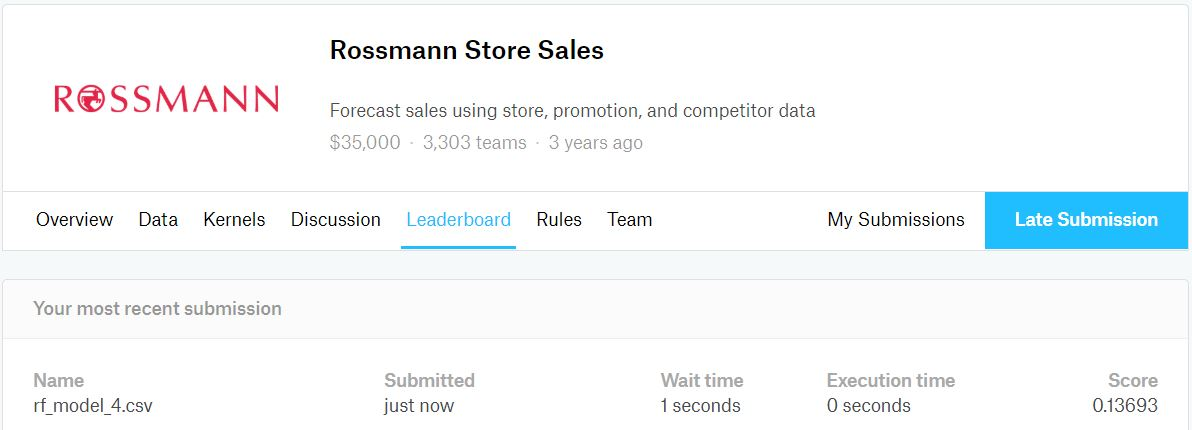

The rmspe score by Kaggle of Random Forest model 4 is 0.13693, which is better than the rmspe score of 0.13852 achieved by Random Forest model 1.

# Export modified datasets as CSVs

Since our modified datasets are becoming quite complicated, let us export them as csv files so that we can use them easily in our future models.

In [25]:
train_sub1.to_csv('train_sub_RFModel4.csv')
train_sub_validation1.to_csv('train_sub_validation_RFModel4.csv')
test1.to_csv('test_RFModel4.csv')